# YEWO: Teaching Machines to Protect Nigeria's Job Seekers  
*Team O3 — August 17, 2025*

> *In Lagos, dawn breaks over a restless city. Somewhere, a graduate is about to lose her life savings to a fake job listing.*  
> **We decided that story ends differently.**

## Mission
We're building an AI-powered early warning system that flags fraudulent job postings before they claim another victim.



## Setup and Initial Data Loading

Here, we load our libraries and datasets.

### Imports Needed

In [66]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Load Local Dataset

In [67]:
try:
    original_df = pd.read_csv('CompiledjobListNigeria.csv')
    print("Original dataset 'CompiledjobListNigeria.csv' loaded successfully!")
    print(f"Original dataset shape: {original_df.shape}")
    print("\nFirst 5 rows of the original data:")
    print(original_df.head())
except FileNotFoundError:
    print("CompiledjobListNigeria.csv' not found.")

Original dataset 'CompiledjobListNigeria.csv' loaded successfully!
Original dataset shape: (202, 10)

First 5 rows of the original data:
                            job_title             company_name  \
0                          Accountant     Equity Model Limited   
1                      Content Writer        CLINTON FUND (CF)   
2                          Accountant  Schleez Nigeria Limited   
3                     Sales Executive  Bons Industries Limited   
4  Bulk/Partnership Marketing Officer          TAMAK LOGISTICS   

                        company_desc  \
0     Accounting, Auditing & Finance   
1  Management & Business Development   
2     Accounting, Auditing & Finance   
3         Marketing & Communications   
4         Marketing & Communications   

                                            job_desc  \
0  Compiling, analyzing, and reporting financial ...   
1  Creating, improving and maintaining content to...   
2  Managing financial transactions, preparing fin...   
3

## Data Augmentation (Creating More Data)

We noticed that the original dataset is small, which can limit the model's ability to learn. So, we decided to create a supplementary dataset of handcrafted, high-confidence examples of both fake and real job postings. This will help the model better recognize strong indicators of fraud and legitimacy.

In [68]:
new_data = [
    # Fake Jobs (label=1)
    {'job_title': 'Urgent Personal Assistant', 'company_name': '', 'company_desc': '', 'job_desc': 'Need a PA ASAP. Send CV to my personal whatsapp on 08012345678. Must pay a small registration fee.', 'job_requirement': 'Smart and ready to work.', 'salary': '200,000 - 300,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Admin', 'label': 1},
    {'job_title': 'Data Entry Clerk - Work From Home', 'company_name': 'Global Solutions Inc.', 'company_desc': 'We are a fast-growing international company.', 'job_desc': 'Easy work from home. Earn 100k weekly. A training fee of 5000 is required for materials. Contact hiring.manager@gmail.com', 'job_requirement': 'Basic computer skills.', 'salary': '100,000 - 150,000', 'location': 'Remote', 'employment_type': 'Contract', 'department': 'Data', 'label': 1},
    {'job_title': 'Oil & Gas Recruitment', 'company_name': '', 'company_desc': 'Upstream Oil Services', 'job_desc': 'Major Oil company is hiring! Limited slots. To get fast-tracked, a clearance fee is required. Contact via Telegram.', 'job_requirement': 'Degree in any field.', 'salary': 'Negotiable', 'location': 'Port Harcourt', 'employment_type': 'Full Time', 'department': 'Engineering', 'label': 1},
    {'job_title': 'Warehouse Officer - Urgent Hire', 'company_name': 'Golden Logistics', 'company_desc': '', 'job_desc': 'Major import/export company needs staff. A one-time payment of 10,000 Naira is required for your port security clearance pass. Send CV to goldenlogisticsjobs@yahoo.com.', 'job_requirement': 'Honest and hardworking.', 'salary': '75,000 - 150,000', 'location': 'Apapa, Lagos', 'employment_type': 'Full Time', 'department': 'Manufacturing & Warehousing', 'label': 1},
    {'job_title': 'Field Officer for NGO Project', 'company_name': 'Health Aid International', 'company_desc': 'NGO dedicated to community health.', 'job_desc': 'Work with international partners. You will be required to get a branded kit and ID card for a fee of 7500 Naira before deployment. Contact Mr. David on WhatsApp.', 'job_requirement': 'Good communication.', 'salary': 'Less than 75,000', 'location': 'Abuja', 'employment_type': 'Contract', 'department': 'Healthcare', 'label': 1},
    {'job_title': 'Business Development Executive', 'company_name': 'Wellness Forever', 'company_desc': '', 'job_desc': 'Join our team of entrepreneurs. Unlimited earning potential. You will be required to purchase a starter pack of our health products to begin.', 'job_requirement': 'Ambitious and driven.', 'salary': 'Commission-based', 'location': 'Ikeja', 'employment_type': 'Part-time', 'department': 'Sales', 'label': 1},
    {'job_title': 'Federal Civil Service Recruitment', 'company_name': '', 'company_desc': 'Federal Government Initiative', 'job_desc': 'Ongoing recruitment for various positions. Applicants must purchase an application PIN for 3000 Naira to access the portal. This is a government requirement.', 'job_requirement': 'OND/HND/BSC', 'salary': 'Government Scale', 'location': 'Nationwide', 'employment_type': 'Full Time', 'department': 'Government', 'label': 1},
    {'job_title': 'Online Form Filler', 'company_name': '', 'company_desc': '', 'job_desc': 'Fill simple online forms and get paid. To get your account, send your full name, BVN, and account details to this WhatsApp number for verification.', 'job_requirement': 'Attention to detail.', 'salary': 'Less than 75,000', 'location': 'Remote', 'employment_type': 'Part-time', 'department': 'Admin', 'label': 1},
    {'job_title': 'Crypto Investment Analyst (Remote)', 'company_name': 'CryptoWealth FX', 'company_desc': 'Global trading platform.', 'job_desc': 'Learn to trade crypto and earn big. No experience needed. A small deposit into a trading account is required to start your portfolio with our guidance.', 'job_requirement': 'Interest in crypto.', 'salary': 'Performance-based', 'location': 'Remote', 'employment_type': 'Contract', 'department': 'Finance', 'label': 1},
    {'job_title': 'Hotel Manager', 'company_name': '', 'company_desc': 'New 5-star hotel opening soon.', 'job_desc': 'A new hotel in Lekki needs a manager. Send your CV to bigboyz_ventures@yahoo.com. Interview is immediate upon payment of processing fee.', 'job_requirement': 'Experience in hospitality.', 'salary': '250,000 - 400,000', 'location': 'Lekki, Lagos', 'employment_type': 'Full Time', 'department': 'Hospitality', 'label': 1},
    {'job_title': 'Nollywood Movie Audition', 'company_name': 'StarQuest Productions', 'company_desc': '', 'job_desc': 'Urgent casting call for new movie. No experience needed. All aspiring actors welcome. A small, refundable fee of 4000 Naira is required for registration and headshot processing. Contact director on WhatsApp.', 'job_requirement': 'Must be confident.', 'salary': 'Negotiable', 'location': 'Surulere, Lagos', 'employment_type': 'Contract', 'department': 'Media & Entertainment', 'label': 1},
    {'job_title': 'Government Loan/Grant Facilitator', 'company_name': '', 'company_desc': 'Federal SME Initiative', 'job_desc': 'Help small businesses access government grants. You must first pay a fee to get your agent accreditation and training materials. High commission. Contact us on grant.agents@gmail.com', 'job_requirement': 'Good people skills.', 'salary': 'Commission-based', 'location': 'Abuja', 'employment_type': 'Full Time', 'department': 'Government', 'label': 1},
    {'job_title': 'Clearing Agent Trainee', 'company_name': 'PortLink Logistics', 'company_desc': '', 'job_desc': 'Learn the import/export business as a clearing agent at the port. A mandatory payment for a "Port Pass" is required before you can be shortlisted. No experience required, we will train you.', 'job_requirement': 'Must be eager to learn.', 'salary': 'Less than 75,000', 'location': 'Apapa, Lagos', 'employment_type': 'Full Time', 'department': 'Shipping & Logistics', 'label': 1},
    {'job_title': 'Home Tutor for Expatriate Family', 'company_name': '', 'company_desc': '', 'job_desc': 'An expatriate family is looking for a home tutor for their children. Attractive salary. You will need to pay for a background check and teaching material package upfront. Contact Mrs. Anabelle on WhatsApp.', 'job_requirement': 'Good with children.', 'salary': '150,000 - 250,000', 'location': 'Victoria Island, Lagos', 'employment_type': 'Part-time', 'department': 'Education', 'label': 1},
    {'job_title': 'Delivery Dispatch Rider', 'company_name': 'QuickErrands', 'company_desc': '', 'job_desc': 'We need dispatch riders urgently. You must make a down payment for the documentation and insurance of the delivery bike which will be assigned to you. Contact us on 080xxxxxxxx.', 'job_requirement': 'Valid rider\'s license.', 'salary': '75,000 - 150,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Driver & Transport Services', 'label': 1},
    {'job_title': 'Client Services Officer', 'company_name': 'Ace Consulting', 'company_desc': '', 'job_desc': 'We are urgently seeking a client services officer. No experience is necessary. A small payment is required for account setup and processing. Contact us via WhatsApp for immediate placement.', 'job_requirement': 'Must be proactive', 'salary': '150,000 - 250,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Customer Service', 'label': 1},
    {'job_title': 'Office Administrator', 'company_name': 'Aluminium Smelting & Refining Sec. NSMI Global Concept', 'company_desc': 'Industrial Processing', 'job_desc': 'Hiring an office administrator. You will be responsible for managing office supplies. A fee for your clearance pass is required before the interview. Please send your CV to our gmail account.', 'job_requirement': 'Good organizational skills.', 'salary': 'Negotiable', 'location': '1–6 Alhaji Lateef Sulaimon Street, Opposite Owode‑Onirin Market, Kosofe LGA, Lagos State, Nigeria', 'employment_type': 'Full Time', 'department': 'Admin', 'label': 1},
    {'job_title': 'Travel Coordinator', 'company_name': 'AMD Travels', 'company_desc': 'Travel and Tours Agency', 'job_desc': 'We need a travel coordinator to help with bookings. A mandatory training fee is required to learn our booking software. Contact us on Telegram to get started.', 'job_requirement': 'Must be computer literate.', 'salary': 'Less than 75,000', 'location': 'Suite 10, Silver Point Plaza, 34 Ogunlana Drive, Surulere, Lagos State, Nigeria', 'employment_type': 'Full Time', 'department': 'Tourism & Travel', 'label': 1},
    {'job_title': 'Project Assistant', 'company_name': 'Archtop Company', 'company_desc': '', 'job_desc': 'Seeking a project assistant for immediate hire. A registration payment is needed to process your application and add you to our system. No experience needed. Contact our manager on WhatsApp.', 'job_requirement': 'Must be a fast learner.', 'salary': '75,000 - 150,000', 'location': 'Suite B, Oba Ogunji Road, Ogba, Lagos State, Nigeria', 'employment_type': 'Full Time', 'department': 'Project Management', 'label': 1},
    {'job_title': 'Marketing Executive', 'company_name': 'Astromag Nigeria Limited', 'company_desc': 'Marketing and Sales', 'job_desc': 'We are looking for marketing executives. A fee for your ID card and marketing materials is required before you can start. This is a commission-based role with high earning potential.', 'job_requirement': 'Good communication skills.', 'salary': 'Commission-based', 'location': 'Oba Akran Avenue, behind AP Filling Station', 'employment_type': 'Contract', 'department': 'Marketing', 'label': 1},
    {'job_title': 'Business Development Officer', 'company_name': 'BetaAge Consult', 'company_desc': 'Consulting Services', 'job_desc': 'Hiring for business development. A payment for a mandatory background check is required before your interview can be scheduled. Please contact us via our yahoo email address.', 'job_requirement': 'Must be a go-getter.', 'salary': '100,000 - 200,000', 'location': 'Plot 12, Alhaji Masha Road, Surulere, Lagos State, Nigeria', 'employment_type': 'Full Time', 'department': 'Business Development', 'label': 1},
    {'job_title': 'Logistics Coordinator', 'company_name': 'BG‑Lead Concept', 'company_desc': '', 'job_desc': 'Urgent need for a logistics coordinator. A clearance fee is required to get your port access pass. No experience needed. Immediate start upon payment.', 'job_requirement': 'Ability to work under pressure.', 'salary': 'Negotiable', 'location': '15 Olowu Street, Off Awolowo Way, Ikeja, Lagos State, Nigeria', 'employment_type': 'Full Time', 'department': 'Logistics', 'label': 1},
    {'job_title': 'HR Assistant', 'company_name': 'BIOCRYSTAL HUMAN CONSULT', 'company_desc': 'HR Consulting', 'job_desc': 'We are hiring an HR assistant. A registration fee is required for your application to be processed. Please contact our HR manager on WhatsApp for the next steps.', 'job_requirement': 'Basic computer skills.', 'salary': 'Less than 75,000', 'location': '147 NTA road opposite Sumec Fireman service center Mgbuoba, PHC.', 'employment_type': 'Full Time', 'department': 'Human Resources', 'label': 1},
    {'job_title': 'Investment Manager', 'company_name': 'Bristow Resources', 'company_desc': '', 'job_desc': 'Looking for an investment manager. A small payment is needed to open your portfolio and for training materials. High returns guaranteed. Contact us via Telegram.', 'job_requirement': 'Good with numbers.', 'salary': 'Performance-based', 'location': '17A, Oyinkan Abayomi Drive, Ikoyi, Lagos State, Nigeria', 'employment_type': 'Contract', 'department': 'Finance', 'label': 1},
    {'job_title': 'Administrative Officer', 'company_name': 'Careerwise', 'company_desc': '', 'job_desc': 'We need an administrative officer. There is a fee for your uniform and ID card which is required before your first day. Please contact us on our gmail for payment details.', 'job_requirement': 'Good organizational skills.', 'salary': '75,000 - 150,000', 'location': 'Suite 16, Olowu Shopping Plaza, 15 Olowu Street, Ikeja, Lagos State, Nigeria', 'employment_type': 'Full Time', 'department': 'Admin', 'label': 1},
    {'job_title': 'Data Entry Clerk', 'company_name': 'CFLEAD', 'company_desc': '', 'job_desc': 'Work from home data entry job. A registration payment is required to get your login details for our portal. Immediate start, no experience needed.', 'job_requirement': 'None', 'salary': '100,000', 'location': 'Remote', 'employment_type': 'Part-time', 'department': 'Data Entry', 'label': 1},
    {'job_title': 'Recruitment Agent', 'company_name': 'CNS Recruitment Team', 'company_desc': '', 'job_desc': 'We are hiring recruitment agents. You must pay for the training materials and agent kit before you can start earning commissions. Contact us on WhatsApp.', 'job_requirement': 'None', 'salary': 'Commission-based', 'location': 'Lagos', 'employment_type': 'Contract', 'department': 'Recruitment', 'label': 1},
    {'job_title': 'Office Manager', 'company_name': 'Crownford Nigeria', 'company_desc': '', 'job_desc': 'Hiring an office manager. A fee for your clearance pass and background check is required before your interview. Please send your CV to our yahoo account.', 'job_requirement': 'Good management skills.', 'salary': 'Negotiable', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Admin', 'label': 1},
    {'job_title': 'Customer Service Rep', 'company_name': 'D’Pearls Consult', 'company_desc': '', 'job_desc': 'We need customer service reps. A small payment is required for your uniform and training materials. No experience needed. Contact us on Telegram.', 'job_requirement': 'Friendly personality.', 'salary': 'Less than 75,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Customer Service', 'label': 1},
    {'job_title': 'Business Manager', 'company_name': 'Dew Platform Plus Resources', 'company_desc': '', 'job_desc': 'Hiring for a business manager. A registration fee is required to get your application processed by our team. Contact us on WhatsApp for immediate consideration.', 'job_requirement': 'Business acumen.', 'salary': '200,000 - 300,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Management', 'label': 1},
    {'job_title': 'Logistics Supervisor', 'company_name': 'Dream Land Enterprises Limited', 'company_desc': '', 'job_desc': 'We need a logistics supervisor. A clearance fee is required to get your port access pass. No experience needed. Immediate start upon payment.', 'job_requirement': 'Ability to manage a team.', 'salary': 'Negotiable', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Logistics', 'label': 1},
    {'job_title': 'Sales Manager', 'company_name': 'Dynamic Associates', 'company_desc': '', 'job_desc': 'We are hiring a sales manager. There is a fee for your training and marketing materials. This is a high-commission role. Contact us on our gmail for payment details.', 'job_requirement': 'Proven sales record.', 'salary': 'Commission-based', 'location': 'Lagos', 'employment_type': 'Contract', 'department': 'Sales', 'label': 1},
    {'job_title': 'Operations Manager', 'company_name': 'Eagle Springs Enterprise', 'company_desc': '', 'job_desc': 'We are looking for an operations manager. A payment for a mandatory background check is required before your interview can be scheduled. Please contact us via our yahoo email address.', 'job_requirement': 'Experience in operations.', 'salary': '150,000 - 250,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Management', 'label': 1},
    {'job_title': 'Training Coordinator', 'company_name': 'Elite (or Elyte) Training', 'company_desc': '', 'job_desc': 'We need a training coordinator. A registration fee is required for your application to be processed. Please contact our HR manager on WhatsApp for the next steps.', 'job_requirement': 'Good organizational skills.', 'salary': '75,000 - 150,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Training', 'label': 1},

    # Real Jobs (label=0)
    {'job_title': 'Senior Software Engineer', 'company_name': 'Paystack', 'company_desc': 'Paystack is a technology company solving payments problems for ambitious businesses.', 'job_desc': 'Looking for a skilled Senior Software Engineer to join our backend team. You will design and implement scalable services.', 'job_requirement': '5+ years experience with Python/Node.js. B.Sc. in Computer Science.', 'salary': 'More than 300,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'IT & Software', 'label': 0},
    {'job_title': 'Marketing Manager', 'company_name': 'Andela', 'company_desc': 'Andela is a global talent network that connects companies with vetted, remote engineers.', 'job_desc': 'Seeking a data-driven Marketing Manager to lead our demand generation strategy in Nigeria.', 'job_requirement': 'Proven experience as a Marketing Manager. Strong understanding of digital marketing tools.', 'salary': 'More than 300,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Marketing & Communications', 'label': 0},
    {'job_title': 'Graduate Trainee Programme 2025', 'company_name': 'Guaranty Trust Bank (GTBank)', 'company_desc': 'Guaranty Trust Bank is a leading African financial institution.', 'job_desc': 'GTBank invites applications from qualified graduates for its 2025 Graduate Trainee Programme.', 'job_requirement': 'Bachelors Degree with minimum 2:1. Completed NYSC. Not older than 26 years.', 'salary': '150,000 - 250,000', 'location': 'Nigeria', 'employment_type': 'Full Time', 'department': 'Banking', 'label': 0},
    {'job_title': 'Network Operations Center (NOC) Engineer', 'company_name': 'MTN Nigeria', 'company_desc': 'MTN Nigeria is part of Africas leading cellular telecommunications company.', 'job_desc': 'Seeking a vigilant NOC Engineer to monitor our network infrastructure, identify issues, and ensure optimal performance.', 'job_requirement': 'B.Sc in Electrical Engineering or Comp Sci. 2+ years experience. CCNA desirable.', 'salary': '250,000 - 400,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'IT & Telecoms', 'label': 0},
    {'job_title': 'Product Manager', 'company_name': 'Flutterwave', 'company_desc': 'Flutterwave is a Nigerian FinTech company that provides payment infrastructure.', 'job_desc': 'Looking for an experienced Product Manager to lead the development of our payment gateway products.', 'job_requirement': '4+ years of product management experience, preferably in FinTech.', 'salary': 'More than 300,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Product Management', 'label': 0},
    {'job_title': 'Quality Assurance Supervisor', 'company_name': 'Nigerian Breweries Plc', 'company_desc': 'The pioneer and largest brewing company in Nigeria.', 'job_desc': 'Responsible for ensuring our products meet the highest quality standards through rigorous testing and process monitoring.', 'job_requirement': 'B.Sc. in a science field (e.g., Microbiology, Biochemistry). 3+ years experience in an FMCG company.', 'salary': '250,000 - 400,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Manufacturing & Warehousing', 'label': 0},
    {'job_title': 'Logistics Coordinator', 'company_name': 'Jumia Nigeria', 'company_desc': 'Jumia is a leading e-commerce platform in Africa.', 'job_desc': 'Coordinate last-mile delivery operations within Lagos. Track shipments, manage delivery agents, and resolve issues to ensure timely delivery.', 'job_requirement': 'Diploma or Degree in Logistics, Supply Chain Management, or a related field.', 'salary': '150,000 - 250,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Shipping & Logistics', 'label': 0},
    {'job_title': 'Audit Associate', 'company_name': 'PricewaterhouseCoopers (PwC)', 'company_desc': 'PwC is a global network of firms delivering assurance, tax and consulting services.', 'job_desc': 'You will be part of a team responsible for performing audits of client financial statements.', 'job_requirement': 'Bachelors degree in Accounting with a minimum 2:1. In the process of qualifying for ICAN/ACCA.', 'salary': '150,000 - 250,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Accounting, Auditing & Finance', 'label': 0},
    {'job_title': 'Lecturer II (Computer Science)', 'company_name': 'University of Lagos', 'company_desc': 'A leading institution of higher learning in Nigeria.', 'job_desc': 'Teach undergraduate courses in Computer Science, conduct research, and supervise student projects.', 'job_requirement': 'PhD or a Masters degree with significant progress towards a PhD in Computer Science.', 'salary': 'Negotiable', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Education', 'label': 0},
    {'job_title': 'Broadcast Journalist', 'company_name': 'Channels Television', 'company_desc': 'An independent and multiple award-winning 24-hour news and media television channel based in Lagos, Nigeria.', 'job_desc': 'Gather news through interviews, observation, and research. Write scripts for broadcasts, and present reports on air.', 'job_requirement': 'Degree in Mass Communication, Journalism, or a related field.', 'salary': '150,000 - 250,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Media & Entertainment', 'label': 0},
    {'job_title': 'Assistant Brand Manager', 'company_name': 'Nestle Nigeria Plc', 'company_desc': 'Nestlé Nigeria Plc is one of the largest food and beverage companies in Africa.', 'job_desc': 'To support the Brand Manager in the development and execution of brand strategies and marketing plans.', 'job_requirement': 'Bachelor\'s Degree in Marketing. A minimum of 2-3 years of relevant experience in brand management within the FMCG sector.', 'salary': '250,000 - 400,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Marketing & Communications', 'label': 0},
    {'job_title': 'Secondary School Mathematics Teacher', 'company_name': 'Greensprings School', 'company_desc': 'A leading British international school in Lagos, Nigeria.', 'job_desc': 'We are seeking an experienced and passionate Mathematics teacher to join our secondary school faculty.', 'job_requirement': 'B.Ed in Mathematics or a B.Sc with a PGDE. Minimum of 3 years of teaching experience.', 'salary': '150,000 - 250,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Education', 'label': 0},
    {'job_title': 'Registered Nurse/Midwife', 'company_name': 'EKO Hospital (EkoCorp Plc)', 'company_desc': 'A leading private healthcare provider in Nigeria, offering a range of specialized medical services.', 'job_desc': 'Provide comprehensive nursing care to patients. Administer medications, monitor patient recovery, and collaborate with doctors.', 'job_requirement': 'Registered Nurse (RN) and Registered Midwife (RM) with a valid license. Minimum of 2 years post-qualification experience.', 'salary': '150,000 - 250,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Healthcare', 'label': 0},
    {'job_title': 'Store Manager', 'company_name': 'Shoprite Nigeria', 'company_desc': 'Africa\'s largest food retailer, operating stores and distribution centres across the continent.', 'job_desc': 'Oversee the daily operations of the store, including inventory management, staff supervision, and customer service.', 'job_requirement': 'HND/B.Sc in Business Administration or a related field. At least 4 years of retail management experience.', 'salary': '250,000 - 400,000', 'location': 'Ibadan', 'employment_type': 'Full Time', 'department': 'Retail', 'label': 0},
    {'job_title': 'Human Resources Officer', 'company_name': 'Dangote Group', 'company_desc': 'One of Nigeria’s most diversified business conglomerates with a hard-earned reputation for excellent business practices.', 'job_desc': 'Assist with the recruitment process, manage employee records, and support the implementation of HR policies.', 'job_requirement': 'B.Sc in Human Resources, Industrial Relations or a similar field. Professional certification (e.g., CIPM) is an advantage.', 'salary': '150,000 - 250,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Human Resources', 'label': 0},
    {'job_title': 'Farm Supervisor', 'company_name': 'Olam Nigeria', 'company_desc': 'A leading food and agri-business company supplying food, ingredients, feed and fibre to thousands of customers worldwide.', 'job_desc': 'Oversee and coordinate the daily activities of farm workers. Responsible for crop management, irrigation, and ensuring that farm operations comply with safety standards.', 'job_requirement': 'Degree in Agriculture, Agronomy, or a related field. Minimum of 3 years of experience in a supervisory role on a commercial farm.', 'salary': '150,000 - 250,000', 'location': 'Kaduna', 'employment_type': 'Full Time', 'department': 'Farming & Agriculture', 'label': 0},
    {'job_title': 'Maintenance Technician (Electrical)', 'company_name': 'Lafarge Africa Plc', 'company_desc': 'A leading Sub-Saharan Africa building solutions company and a member of Holcim.', 'job_desc': 'Perform preventive and corrective maintenance on electrical systems and equipment within the plant. Troubleshoot faults and ensure machinery is running efficiently and safely.', 'job_requirement': 'OND/HND in Electrical Engineering. Trade Test certification is required. Minimum of 4 years experience as an industrial electrician.', 'salary': '150,000 - 250,000', 'location': 'Ewekoro, Ogun State', 'employment_type': 'Full Time', 'department': 'Engineering & Technology', 'label': 0},
    {'job_title': 'Paralegal', 'company_name': 'Aluko & Oyebode', 'company_desc': 'A top-tier full-service law firm in Nigeria, providing legal services to a diverse range of clients.', 'job_desc': 'Assist lawyers with legal research, drafting legal documents, and managing case files. Responsible for maintaining the firm\'s legal library and databases.', 'job_requirement': 'A good university degree in Law (LLB). Completion of the Nigerian Law School (BL) is a strong advantage.', 'salary': '150,000 - 250,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Law & Compliance', 'label': 0},
    {'job_title': 'Program Officer, Health', 'company_name': 'Tony Elumelu Foundation', 'company_desc': 'An African non-profit organization founded in 2010 with the objective of empowering African entrepreneurs.', 'job_desc': 'Support the planning, implementation, and monitoring of health-focused initiatives within our entrepreneurship program. Collaborate with partners and stakeholders to achieve program goals.', 'job_requirement': 'Master\'s degree in Public Health, Development Studies, or a related field. Minimum of 3 years experience in project management within the non-profit sector.', 'salary': '250,000 - 400,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'NGO, NPO & Charity', 'label': 0},
    {'job_title': 'Architectural Technologist', 'company_name': 'ATO Architects', 'company_desc': 'A multi-disciplinary design firm offering services in architecture, urban design, and interior design, with a focus on creating sustainable and innovative buildings.', 'job_desc': 'Work closely with architects to produce detailed technical drawings, building plans, and construction documents using CAD software. Ensure designs comply with building codes and regulations.', 'job_requirement': 'HND/B.Tech in Architectural Technology. Proficiency in AutoCAD, Revit, and other design software is essential. Minimum of 3 years of relevant experience.', 'salary': '150,000 - 250,000', 'location': 'Abuja', 'employment_type': 'Full Time', 'department': 'Building & Architecture', 'label': 0},
    {'job_title': 'Junior Frontend Developer', 'company_name': 'Shuttlers', 'company_desc': 'Shuttlers is a tech-enabled scheduled bus-sharing company that provides comfortable, safe, and affordable transportation for professionals in Lagos.', 'job_desc': 'We are a small, passionate team building a new mobile app for the transport sector. We\'re looking for a junior developer who is eager to learn and grow with us. You\'ll be working directly with the founders to build out our user interface.', 'job_requirement': 'Some experience with React or Vue. A good eye for design. Please share your GitHub profile with your application.', 'salary': '150,000 - 250,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'IT & Software', 'label': 0},
    {'job_title': 'Product Marketing Intern', 'company_name': 'Paystack', 'company_desc': 'Paystack helps businesses in Africa get paid by anyone, anywhere in the world.', 'job_desc': 'We\'re looking for a creative and analytical intern to join our product marketing team. You will help us launch new features, create compelling content, and understand our user base. This is a hands-on role with real impact.', 'job_requirement': 'Excellent writing skills. Passionate about technology and solving problems for African businesses. Currently studying or a recent graduate.', 'salary': '100,000 - 150,000', 'location': 'Lagos', 'employment_type': 'Internship', 'department': 'Marketing & Communications', 'label': 0},
    {'job_title': 'Customer Success Associate', 'company_name': 'Helium Health', 'company_desc': 'Helium Health is the leading provider of full-service technology solutions for healthcare stakeholders in Africa.', 'job_desc': 'As a Customer Success Associate, you will be the primary contact for our partner hospitals. You\'ll be responsible for onboarding, training, and ensuring they get the most value from our platform. We need a problem-solver with great empathy.', 'job_requirement': '1-2 years experience in a customer-facing role. Strong communication and problem-solving skills. A passion for improving healthcare in Africa.', 'salary': '150,000 - 250,000', 'location': 'Lagos', 'employment_type': 'Full Time', 'department': 'Customer Service & Support', 'label': 0}
    ]
original_augment_df = pd.DataFrame(new_data)

cdf = pd.concat([original_df, original_augment_df], ignore_index=True, sort=False)
cdf.drop_duplicates(subset=['job_title', 'company_name', 'job_desc'], inplace=True, keep='last')
combined_df = cdf

## More Data and Model Training (Global Data)


International dataset loaded successfully with 17880 rows.
Training the Global Expert model...
Global Expert model training complete!

Global Model Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.99      0.94      0.97      3403
    Fake (1)       0.42      0.85      0.56       173

    accuracy                           0.94      3576
   macro avg       0.71      0.89      0.76      3576
weighted avg       0.96      0.94      0.95      3576


Global Model Confusion Matrix:


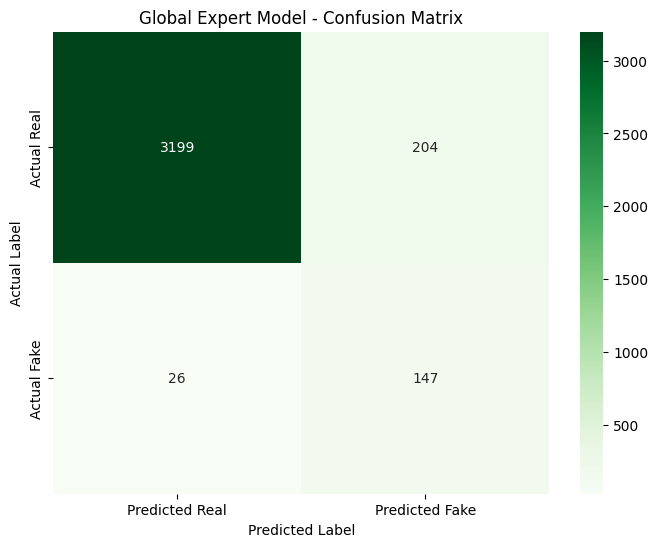

Final Model Accuracy with Tuned Threshold: 93.57%


In [69]:
try:
    global_df = pd.read_csv('fake_job_postings.csv', engine='python', on_bad_lines='skip')
    print(f"International dataset loaded successfully with {global_df.shape[0]} rows.")

    global_df['text'] = global_df['title'].fillna('') + ' ' + global_df['description'].fillna('') + ' ' + global_df['requirements'].fillna('')
    global_df.dropna(subset=['text', 'fraudulent'], inplace=True)
    X_global = global_df['text']
    y_global = global_df['fraudulent']

    X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(
        X_global, y_global, test_size=0.2, random_state=42, stratify=y_global
    )

    global_model_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=2000)),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ])

    print("Training the Global Expert model...")
    global_model_pipeline.fit(X_train_global, y_train_global)
    print("Global Expert model training complete!")

    y_pred_global = global_model_pipeline.predict(X_test_global)

    print("\nGlobal Model Classification Report:")
    print(classification_report(y_test_global, y_pred_global, target_names=['Real (0)', 'Fake (1)']))

    print("\nGlobal Model Confusion Matrix:")
    cm_global = confusion_matrix(y_test_global, y_pred_global)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Predicted Real', 'Predicted Fake'],
                yticklabels=['Actual Real', 'Actual Fake'])
    plt.title('Global Expert Model - Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    accuracy = accuracy_score(y_test_global, y_pred_global)
    print(f"Final Model Accuracy with Tuned Threshold: {accuracy:.2%}")

except FileNotFoundError:
    print("'fake_job_postings.csv' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

## Feature Engineering
Now, we apply our feature engineering function to the new, larger, combined dataset. This ensures our model learns from both the original and the augmented data.

Features Created:
- has_company_profile
- has_requirements
- has_benefits
- description_length
- company_profile_length
- red_flag_count (counts keywords like "whatsapp", "fee", etc.)
- percent_caps
- exclamation_count

In [70]:
def create_features(df):
    text_cols = ['job_title', 'company_name', 'company_desc', 'job_desc', 'job_requirement',
                 'salary', 'location', 'employment_type', 'department']
    for col in text_cols:
        df[col] = df[col].fillna('')

    df['has_company_name'] = (df['company_name'].str.len() > 3).astype(int)
    df['has_company_desc'] = (df['company_desc'].str.len() > 10).astype(int)
    df['has_job_requirement'] = (df['job_requirement'].str.len() > 10).astype(int)
    df['job_desc_length'] = df['job_desc'].apply(len)
    df['company_desc_length'] = df['company_desc'].apply(len)

    df['full_text'] = df['job_title'] + ' ' + df['job_desc'] + ' ' + df['job_requirement']
    df['full_text_lower'] = df['full_text'].str.lower()
    red_flags = ["whatsapp", "telegram", "fee", "payment", "registration", "urgent", "asap",
                 "no experience", "training fee", "interview fee", "clearance", "bvn"]
    red_flag_count = df['full_text_lower'].apply(lambda x: sum(flag in x for flag in red_flags))

    personal_emails = ["@gmail.com", "@yahoo.com", "@outlook.com"]
    has_personal_email = df['full_text_lower'].apply(lambda x: 1 if any(email in x for email in personal_emails) else 0)

    phone_pattern = r'(?:(?:\+234|0)[789][01]\d{8})'
    has_mobile_number = df['full_text'].apply(lambda x: 1 if re.search(phone_pattern, x) else 0)
    df['scam_score'] = (red_flag_count * 3) + (has_personal_email * 3) + (has_mobile_number * 3)
    df['percent_caps'] = df['job_desc'].apply(lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1))
    df['exclamation_count'] = df['job_desc'].str.count('!')

    df = df.drop(columns=['full_text', 'full_text_lower'])
    return df

featured_df = create_features(combined_df.copy())
print(f"Featured dataset shape: {featured_df.shape}")
print("Feature engineering complete!")

Featured dataset shape: (250, 18)
Feature engineering complete!


## Model Training and Evaluation (Local Data)

- **Objective**: To train a machine learning model to distinguish between fake and real job postings using the features we created. We will then rigorously evaluate its performance on data it has never seen before.
- **Methodology**:
  - **Feature Selection**: We will select the most predictive features from our dataset. This includes our engineered features and some original categorical data.
  - **Preprocessing**: Machine learning models only understand numbers. We will convert our selected data into a fully numerical format. We'll use a Pipeline to handle this professionally, applying StandardScaler to numerical columns and OneHotEncoder to categorical columns.
  - **Train-Test Split**: We will split our data into a training set (80%) for the model to learn from, and a testing set (20%) to evaluate its real-world performance.
  - **Model Training**: We will use a RandomForestClassifier. This is a powerful and reliable model that works well for this type of problem because it combines many decision trees to make a final prediction, reducing the risk of error.
  - **Evaluation**: We will assess the model using key metrics:
  - **Accuracy**: Overall, how often is the model correct?
  - **Confusion Matrix**: A visual breakdown of correct vs. incorrect predictions for each class.
  - **Classification Report**: A detailed report showing Precision (how many of our "fake" predictions were actually fake?) and Recall (of all the actual fake jobs, how many did we successfully find?). For this problem, high recall for the "fake" class is our most important goal.

Model training complete!
              precision    recall  f1-score   support

    Real (0)       0.94      1.00      0.97        30
    Fake (1)       1.00      0.90      0.95        20

    accuracy                           0.96        50
   macro avg       0.97      0.95      0.96        50
weighted avg       0.96      0.96      0.96        50

New Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

    Real (0)       0.94      1.00      0.97        30
    Fake (1)       1.00      0.90      0.95        20

    accuracy                           0.96        50
   macro avg       0.97      0.95      0.96        50
weighted avg       0.96      0.96      0.96        50


Final Confusion Matrix (Safer Threshold):


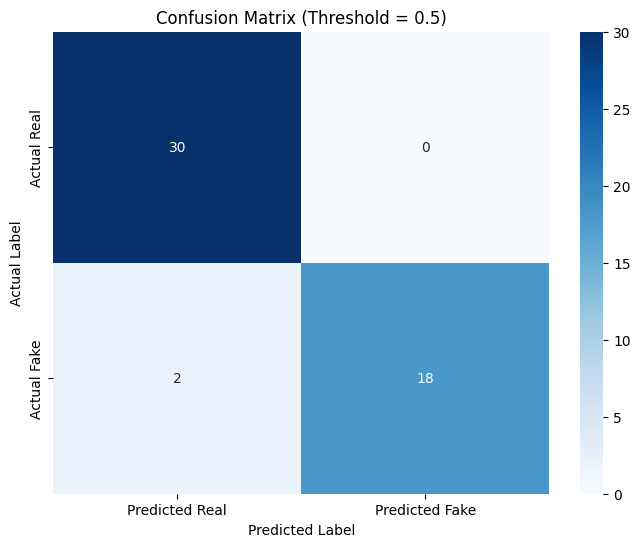

Final Model Accuracy with Tuned Threshold: 96.00%


In [71]:
y = featured_df['label']
numeric_features = [
    'job_desc_length', 'company_desc_length', 'percent_caps', 'exclamation_count', 'scam_score'
]
categorical_features = [
    'employment_type', 'department', 'has_company_name', 'has_company_desc', 'has_job_requirement'
]
X = featured_df[numeric_features + categorical_features].copy()
X[categorical_features] = X[categorical_features].fillna('Missing')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
pipeline.fit(X_train, y_train)
print("Model training complete!")

y_pred_default = pipeline.predict(X_test)
print(classification_report(y_test, y_pred_default, target_names=['Real (0)', 'Fake (1)']))

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

NEW_THRESHOLD = 0.50
y_pred_tuned = (y_pred_proba >= NEW_THRESHOLD).astype(int)

print(f"New Classification Report (Threshold = {NEW_THRESHOLD}):")
print(classification_report(y_test, y_pred_tuned, target_names=['Real (0)', 'Fake (1)']))

print("\nFinal Confusion Matrix (Safer Threshold):")
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])
plt.title(f'Confusion Matrix (Threshold = {NEW_THRESHOLD})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"Final Model Accuracy with Tuned Threshold: {accuracy:.2%}")

## Saving the Model

In [72]:
folder_name = "models"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

nigerian_model_path = os.path.join(folder_name, 'yewo.joblib')
global_model_path = os.path.join(folder_name, 'yewo2.joblib')

try:
    print(f"Saving Nigerian model to: {nigerian_model_path}")
    joblib.dump(pipeline, nigerian_model_path)

    print(f"Saving Global Expert model to: {global_model_path}")
    joblib.dump(global_model_pipeline, global_model_path)

    print("\nModels saved successfully inside the 'models' folder!")
    print("\nIMPORTANT: You will need to download the entire 'models' folder or the individual files within it.")

except NameError as e:
    print(f"\nERROR: A model was not found. Please ensure you have run all the training cells above. Details: {e}")

Folder 'models' already exists.
Saving Nigerian model to: models/yewo.joblib
Saving Global Expert model to: models/yewo2.joblib

Models saved successfully inside the 'models' folder!

IMPORTANT: You will need to download the entire 'models' folder or the individual files within it.
